# Modèle Baseline: Régression logistique

Dans ce notebook, je vais utilider le modèle de régression logistique pour prédire le sentiment des tweets.

In [1]:
import sys
sys.path.append('../src')  # Add the src folder to the module search path
from utils import Utils
import os
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Maths modules
from scipy.stats import f_oneway
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# precision, recall, f1-score,
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

# Vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

## Charger des données nettoyées à partir d'un fichier CSV

In [2]:
df = pd.read_csv('D:/openclassroom/projet7/input/df_cleaned_docs.csv',encoding='ISO-8859-1')

In [3]:
df.head()

,target,text,clean_text
0,NEGATIVE,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom awww s bummer should...
1,NEGATIVE,is upset that he can't update his Facebook by ...,upset not update facebook texte cry result sch...
2,NEGATIVE,@Kenichan I dived many times for the ball. Man...,kenichan dive time ball manage save rest bound
3,NEGATIVE,my whole body feels itchy and like its on fire,body feel itchy like fire
4,NEGATIVE,"@nationwideclass no, it's not behaving at all....",nationwideclass behave m mad not


In [4]:
df.shape

(1597489, 3)

['NEGATIVE' 'POSITIVE']


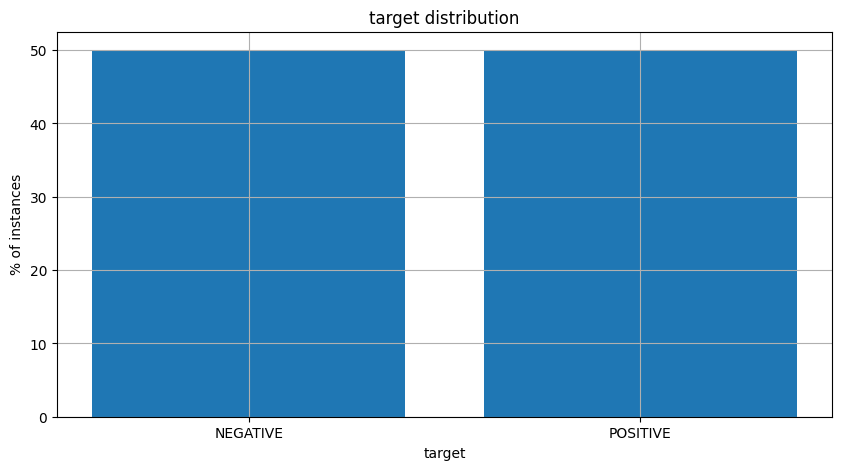

In [5]:
# the histogram of the data
labels = df['target'].unique()
print(labels)
post_total = len(df)
df1 = df.groupby(['target']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('target')
plt.title('target distribution')
plt.grid(True)
plt.show()

## Extraction de caractéristiques

Avant de pouvoir entraîner notre modèle, nous allons vectoriser les documents avec le modèle Tf-Idf Vectorizer (Term Frequency - Inverted Document Frequency) pour extraire des caractéristiques

In [6]:

# pd.DataFrame.sparse.from_spmatrix function is used to reduce memory usage
tokenized_docs = df.clean_text
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(tokenized_docs)
df_doc_vec = pd.DataFrame.sparse.from_spmatrix(doc_vec, columns=vectorizer.get_feature_names_out())
df_doc_vec.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,...,âºvida,âºâµn,âºâµng,âºâºã,âºã,ãª,ãªâµ,ã³,ã¹,ãº
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Réduction de dimension
Car la régression mogistique n'est pas capable de modéliser sur de grandes données, nous utilisons donc la méthode Latent Semantic Analysis (LSA) pour réduire la dimension de la représentation BoW. Cette méthode va créer des sujets qui sont les plus pertinents pour le corpus.

In [7]:

# Train LSA model
n_components = 20
X = df_doc_vec
lsa = TruncatedSVD(n_components=n_components, random_state=42).fit(X)

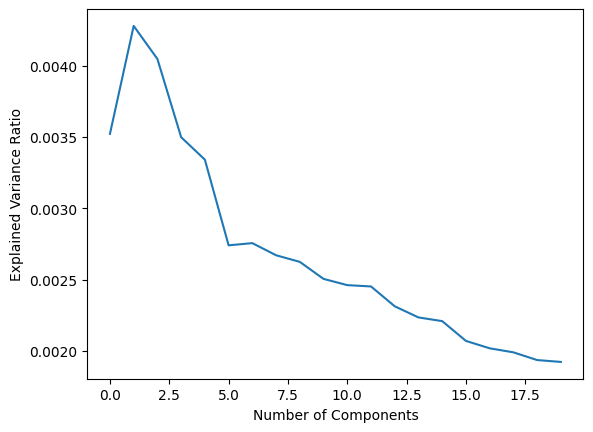

In [8]:
# Plot the explained variance ratio
plt.plot(lsa.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [9]:
def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols,figsize=(30, n_lines * 5), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

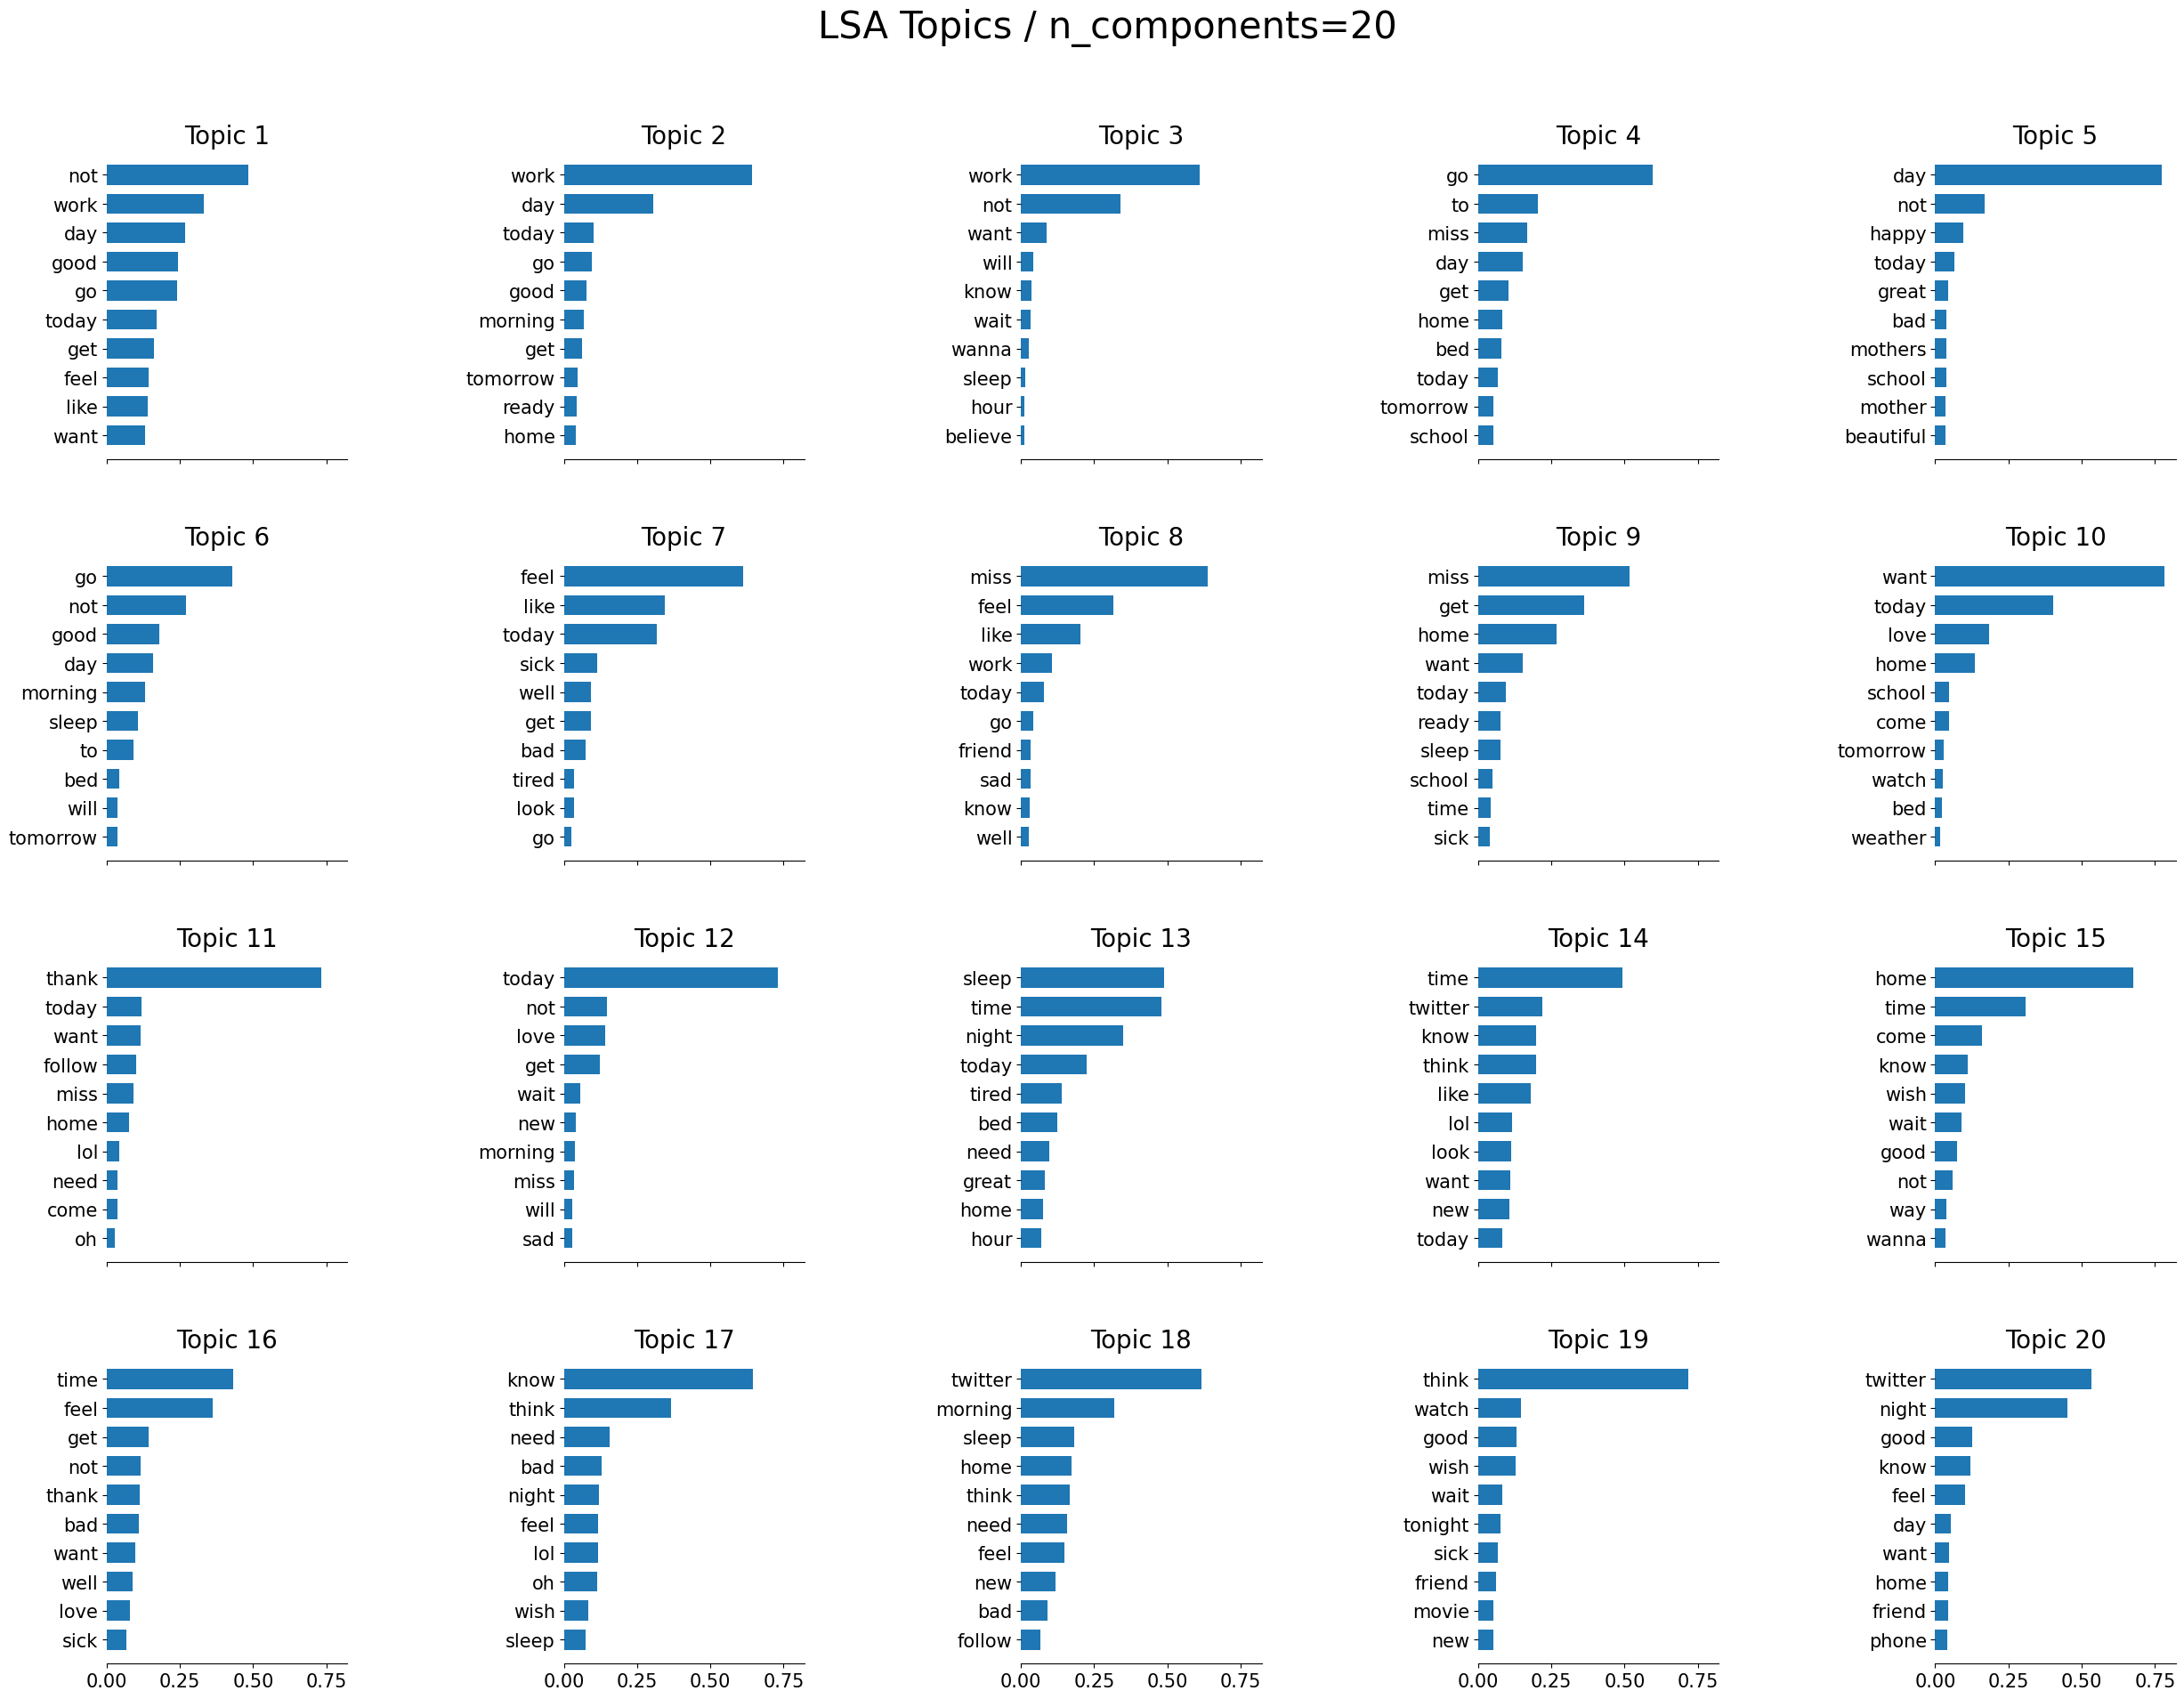

In [10]:

# Plot the top words of each topic
plot_top_words(
        model=lsa,
        feature_names=df_doc_vec.columns,
        n_top_words=10,
        n_topics=50, title=f"LSA Topics / n_components={n_components}")

In [11]:
X_lsa = lsa.transform(X)
y = df['target'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lsa,y,test_size=0.2,random_state=42)

## Régression logistique

In [12]:

# build Logistic Regression
LR_model = LogisticRegressionCV(random_state=42, cv=10)

# training!
LR_model.fit(X_train,y_train)

# predict!
y_train_pred = LR_model.predict(X_train)
y_test_pred = LR_model.predict(X_test)

In [13]:
# accuracy

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.65
testing accuracy: 0.65


In [15]:
cf = confusion_matrix(y_train, y_train_pred)
make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title = "Performance du modèle sur le training")

NameError: name 'make_confusion_matrix' is not defined

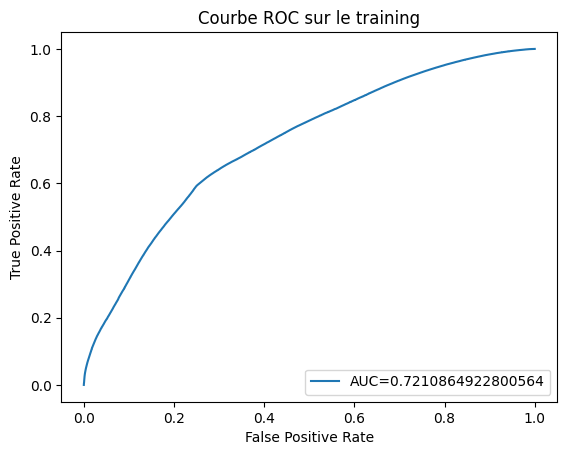

In [36]:
y_pred_proba = LR_model.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)
auc = roc_auc_score(y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Courbe ROC sur le training")
plt.show()

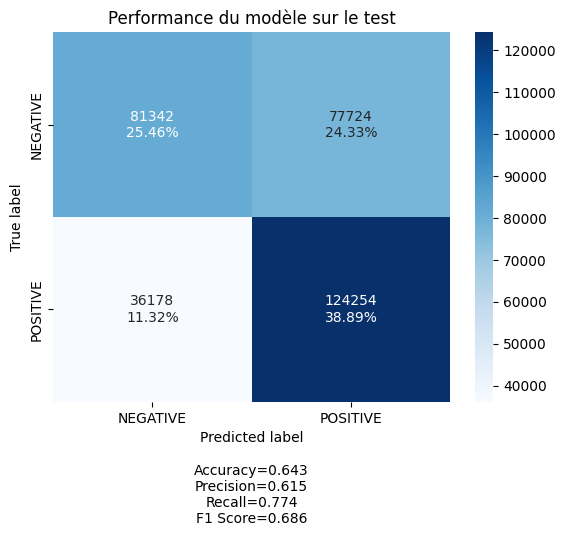

In [60]:
cf = confusion_matrix(y_test, y_test_pred)
make_confusion_matrix(cf, categories=['NEGATIVE', 'POSITIVE'], title = "Performance du modèle sur le test")

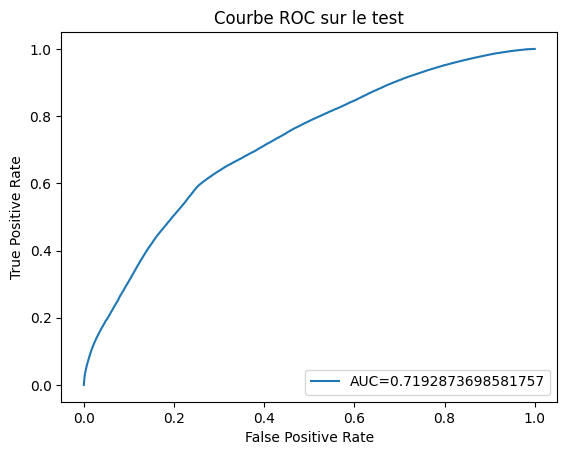

In [38]:

y_pred_proba = LR_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(l_y_test,  y_pred_proba)
auc = metrics.roc_auc_score(l_y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("Courbe ROC sur le test")
plt.show()

## Run MLFlow

In [22]:
import mlflow
mlflow.set_experiment(experiment_name = "p7-baseline model")
name_model = "logistic_regression"
mlflow.autolog()
mlflow.set_tracking_uri("sqlite:///mlruns.db")

with mlflow.start_run(run_name=name_model) as run:
    mlk.autolog()
    LR_model = LogisticRegressionCV(random_state=42, cv=10)
    LR_model.fit(X_train,y_train)
    y_train_pred = LR_model.predict(X_train)
    y_valid_pred = LR_model.predict(X_test)
    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_valid = accuracy_score(y_true=y_valid, y_pred=y_valid_pred)
    y_train_pred_proba = LR_model.predict_proba(X_train)[::,1]
    y_valid_pred_proba = LR_model.predict_proba(X_valid)[::,1]
    roc_train = metrics.roc_auc_score(y_train, y_train_pred_proba)
    roc_valid = metrics.roc_auc_score(y_valid, y_valid_pred_proba)
    #logging the metrics of our run
    mlflow.log_metric("acc_train", acc_train)
    mlflow.log_metric("roc_train", acc_valid)
    mlflow.log_metric("acc_valid", f_n)
    mlflow.log_metric("roc_valid", t_p)



2023/06/02 10:52:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/02 10:52:45 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


CommandError: Can't locate revision identified by '3500859a5d39'

In [29]:
mlflow.set_experiment(experiment_name="p7-baseline model")
name_model = "logistic_regression"
#mlflow.autolog()
#mlflow.set_tracking_uri("sqlite:///mlruns.db")

with mlflow.start_run(run_name=name_model) as run:
    LR_model = LogisticRegressionCV(random_state=42, cv=10)
    LR_model.fit(X_train, y_train)
    y_train_pred = LR_model.predict(X_train)
    y_valid_pred = LR_model.predict(X_test)
    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_valid = accuracy_score(y_true=y_valid, y_pred=y_valid_pred)
    y_train_pred_proba = LR_model.predict_proba(X_train)[::,1]
    y_valid_pred_proba = LR_model.predict_proba(X_test)[::,1]
    roc_train = roc_auc_score(y_train, y_train_pred_proba)
    roc_valid = roc_auc_score(y_valid, y_valid_pred_proba)
    
    # logging the metrics of our run
    mlflow.log_metric("acc_train", acc_train)
    mlflow.log_metric("roc_train", roc_train)
    mlflow.log_metric("acc_valid", acc_valid)
    mlflow.log_metric("roc_valid", roc_valid)

2023/06/02 10:58:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/02 10:58:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


CommandError: Can't locate revision identified by '3500859a5d39'